### Training of modified U-Net for Optic Disc on DRISHTI-GS database (cross-validation fold #0).

512 px cropped by Optic Disc area and resized to 128 px images were used.

You can either train your model or upload a pre-trained one from:
*../models_weights/02.03,13:57,OD Cup, U-Net light on DRISHTI-GS 512 px cropped to OD 128 px fold 0, SGD, log_dice loss/last_checkpoint.hdf5*

In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import os
import glob
from datetime import datetime
#import warnings
#warnings.simplefilter('ignore')
import scipy as sp
import scipy.ndimage
import numpy as np
import pandas as pd
import skimage
import skimage.exposure
from sklearn.cross_validation import KFold
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import h5py
from tqdm import tqdm_notebook
import mahotas as mh
from IPython.display import display
from dual_IDG import DualImageDataGenerator

In [15]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, \
    Convolution2D, MaxPooling2D, ZeroPadding2D, Input, Embedding, LSTM, merge, \
    Lambda, UpSampling2D
from keras.utils import np_utils
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, CSVLogger
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

In [16]:
K.set_image_dim_ordering('th')

In [17]:
def tf_to_th_encoding(X):
    return np.rollaxis(X, 3, 1)


def th_to_tf_encoding(X):
    return np.rollaxis(X, 1, 4)

### Loading Data

(50, 3, 128, 128)


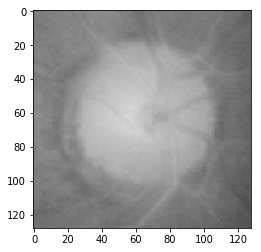

In [35]:
#loading data on which predictions are to be made
from glob import glob
import matplotlib.image as mpimg

loc = glob(os.path.join('/home/dic/Desktop/hackslash/input_image', "*.png"))
X = list()
for img in loc:
    image1 = mpimg.imread(img)
    image1 = np.array(image1)
    image1 = cv2.resize(image1, (128,128))
    b,g,r = cv2.split(image1)
    image1 = cv2.merge((b,b,b))
    X.append(image1)
X = np.array(X)
X = tf_to_th_encoding(X)
print(X.shape)
plt.imshow(image1)

In [36]:
#model for Disc

import cv2
def get_unet_light(img_rows=256, img_cols=256):
    inputs = Input((3, img_rows, img_cols))
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(inputs)
    #conv1 = #Dropout(0.6)(conv1)
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv1)
    #conv1 = #Dropout(0.6)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool1)
    #conv2 = #Dropout(0.6)(conv2)
    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool2)
    #conv3 = #Dropout(0.6)(conv3)
    conv3 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool3)
    #conv4 = #Dropout(0.6)(conv4)
    conv4 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool4)
    #conv5 = #Dropout(0.6)(conv5)
    conv5 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv5)

    up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=1)
    conv6 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up6)
    #conv6 = #Dropout(0.6)(conv6)
    conv6 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv6)

    up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=1)
    conv7 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up7)
    #conv7 = #Dropout(0.6)(conv7)
    conv7 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv7)

    up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=1)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up8)
    #conv8 = #Dropout(0.6)(conv8)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv8)

    up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=1)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(up9)
    #conv9 = #Dropout(0.6)(conv9)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv9)
    #conv9 = #Dropout(0.6)(conv9)

    conv10 = Convolution2D(1, 1, 1, activation='sigmoid')(conv9)
    #conv10 = Flatten()(conv10)

    model = Model(input=inputs, output=conv10)

    return model


In [37]:
model = get_unet_light(img_rows=128, img_cols=128)

/home/dic/anaconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same")`
  
/home/dic/anaconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same")`
  
/home/dic/anaconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  if sys.path[0] == '':
/home/dic/anaconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  
/home/dic/anaconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", p

In [38]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 3, 128, 128)  0                                            
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 32, 128, 128) 896         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 32, 128, 128) 9248        conv2d_39[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 32, 64, 64)   0           conv2d_40[0][0]                  
__________________________________________________________________________________________________
conv2d_41 

In [39]:
#load disc model
import glob
model_name = 'Best_so_far_disc_gray.hdf5'
model_path = max(glob.glob(os.path.join(os.getcwd(), model_name)), key=os.path.getctime)
model.load_weights(model_path)

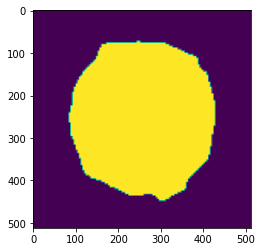

In [40]:
#Predicting disc
timages = '/home/dic/Desktop/hackslash/disc/'
for i in range(X.shape[0]):
    
    batch_X = X[i:i + 1]
    
    pred = (model.predict(batch_X)[0, 0] > 0.5).astype(np.float64)
    v=str(i)
    tim = timages + v + '.png'
    pred = pred * 255
    pred = cv2.resize(pred, (512,512))
    cv2.imwrite(tim, pred)
plt.imshow(pred)

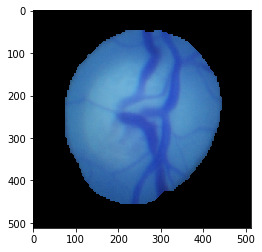

In [41]:
#make input image for cup from prediction of disc
from glob import glob
X_cup = list()
loc = glob(os.path.join('/home/dic/Desktop/hackslash/input_image', "*.png"))
loc2 = '/home/dic/Desktop/hackslash/disc/'
loc3 = '/home/dic/Desktop/hackslash/disc_crop/'
i = 0
for img in loc:
    val = str(i)
    extn = '.png'

    img2 = loc2 + val + extn
    img3 = loc3 + val + extn
    image1 = cv2.imread(img)
    image2 = cv2.imread(img2)
    gray_image = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

    _, thresh = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY)

    b,g,r = cv2.split(image1)
    b_and_image = cv2.bitwise_and(b, thresh)
    g_and_image = cv2.bitwise_and(g, thresh)
    r_and_image = cv2.bitwise_and(r, thresh)

    and_image = cv2.merge((b_and_image, g_and_image, r_and_image))


    cv2.imwrite(img3, and_image)

    X_cup.append(and_image)
    i += 1
X_cup = np.array(X_cup)
X_cup= X_cup/255
plt.imshow(X_cup[0])

In [42]:
import cv2
def get_unet_light(img_rows=256, img_cols=256):
    inputs = Input((3, img_rows, img_cols))
    conv1 = Convolution2D(34, 4, 2, activation='relu', border_mode='same')(inputs)
    #conv1 = #Dropout(0.6)(conv1)
    conv1 = Convolution2D(34, 4, 2, activation='relu', border_mode='same')(conv1)
    #conv1 = #Dropout(0.6)(conv1)
    pool1 = MaxPooling2D(pool_size=(4, 4))(conv1)

    conv2 = Convolution2D(64, 4, 4, activation='relu', border_mode='same')(pool1)
    #conv2 = #Dropout(0.6)(conv2)
    conv2 = Convolution2D(64, 4, 4, activation='relu', border_mode='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(4, 4))(conv2)

    conv3 = Convolution2D(64, 4, 4, activation='relu', border_mode='same')(pool2)
    #conv3 = #Dropout(0.6)(conv3)
    conv3 = Convolution2D(64, 4, 4, activation='relu', border_mode='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(4, 4))(conv3)

    conv4 = Convolution2D(64, 4, 4, activation='relu', border_mode='same')(pool3)
    #conv4 = #Dropout(0.6)(conv4)
    conv4 = Convolution2D(64, 4, 4, activation='relu', border_mode='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(4, 4))(conv4)

    conv5 = Convolution2D(64, 4, 4, activation='relu', border_mode='same')(pool4)
    #conv5 = #Dropout(0.6)(conv5)
    conv5 = Convolution2D(64, 4, 4, activation='relu', border_mode='same')(conv5)

    up6 = merge([UpSampling2D(size=(4, 4))(conv5), conv4], mode='concat', concat_axis=1)
    conv6 = Convolution2D(64, 4, 4, activation='relu', border_mode='same')(up6)
    #conv6 = #Dropout(0.6)(conv6)
    conv6 = Convolution2D(64, 4, 4, activation='relu', border_mode='same')(conv6)

    up7 = merge([UpSampling2D(size=(4, 4))(conv6), conv3], mode='concat', concat_axis=1)
    conv7 = Convolution2D(64, 4, 4, activation='relu', border_mode='same')(up7)
    #conv7 = #Dropout(0.6)(conv7)
    conv7 = Convolution2D(64, 4, 4, activation='relu', border_mode='same')(conv7)

    up8 = merge([UpSampling2D(size=(4, 4))(conv7), conv2], mode='concat', concat_axis=1)
    conv8 = Convolution2D(64, 4, 4, activation='relu', border_mode='same')(up8)
    #conv8 = #Dropout(0.6)(conv8)
    conv8 = Convolution2D(64, 4, 4, activation='relu', border_mode='same')(conv8)

    up9 = merge([UpSampling2D(size=(4, 4))(conv8), conv1], mode='concat', concat_axis=1)
    conv9 = Convolution2D(34, 4, 2, activation='relu', border_mode='same')(up9)
    #conv9 = #Dropout(0.6)(conv9)
    conv9 = Convolution2D(34, 4, 2, activation='relu', border_mode='same')(conv9)
    #conv9 = #Dropout(0.6)(conv9)

    conv10 = Convolution2D(1, 1, 1, activation='sigmoid')(conv9)
    #conv10 = Flatten()(conv10)

    model = Model(input=inputs, output=conv10)

    return model

In [43]:
model = get_unet_light(img_rows=512, img_cols=512)

/home/dic/anaconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(34, (4, 2), activation="relu", padding="same")`
  after removing the cwd from sys.path.
/home/dic/anaconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(34, (4, 2), activation="relu", padding="same")`
  
/home/dic/anaconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (4, 4), activation="relu", padding="same")`
  # Remove the CWD from sys.path while we load stuff.
/home/dic/anaconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (4, 4), activation="relu", padding="same")`
  if sys.path[0] == '':
/home/dic/anaconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning

In [44]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 3, 512, 512)  0                                            
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 34, 512, 512) 850         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_59 (Conv2D)              (None, 34, 512, 512) 9282        conv2d_58[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_13 (MaxPooling2D) (None, 34, 128, 128) 0           conv2d_59[0][0]                  
__________________________________________________________________________________________________
conv2d_60 

### Loading model

In [45]:
import glob
model_name = 'best_ever_cup.hdf5'
model_path = max(glob.glob(os.path.join(os.getcwd(), model_name)), key=os.path.getctime)
model.load_weights(model_path)

### Prediction of Cup

In [46]:
#Prediction on validation data
timages = '/home/dic/Desktop/hackslash/cup/'
for i in range(X_cup.shape[0]):    
    batch_X = X_cup[i:i + 1]
    batch_X = tf_to_th_encoding(batch_X)
    pred = (model.predict(batch_X)[0, 0] > 0.5).astype(np.float64)
    
    v=str(i)
    tim = timages + v + '.png'
    pred = pred * 255
    cv2.imwrite(tim, pred)
    pred =pred / 255.0
    

/home/dic/Desktop/hackslash/glycoma/unet1/aug/1d.png


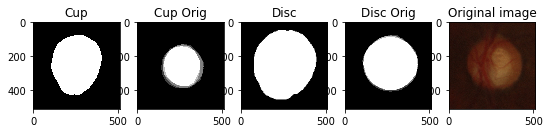

/home/dic/Desktop/hackslash/glycoma/unet1/aug/2d.png


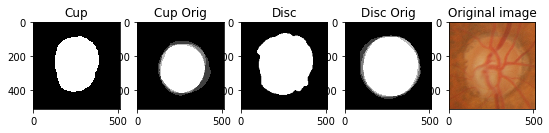

/home/dic/Desktop/hackslash/glycoma/unet1/aug/3d.png


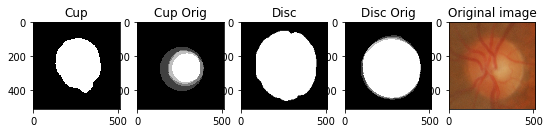

/home/dic/Desktop/hackslash/glycoma/unet1/aug/4d.png


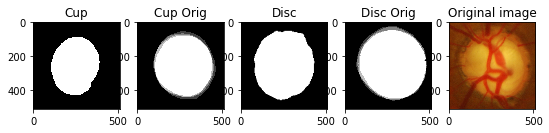

/home/dic/Desktop/hackslash/glycoma/unet1/aug/5d.png


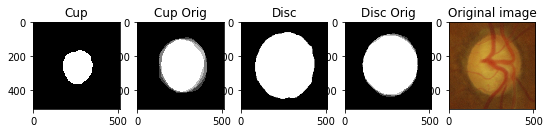

/home/dic/Desktop/hackslash/glycoma/unet1/aug/6d.png


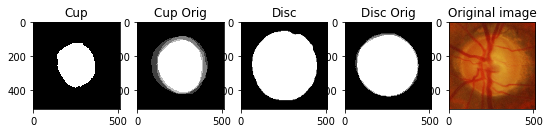

/home/dic/Desktop/hackslash/glycoma/unet1/aug/7d.png


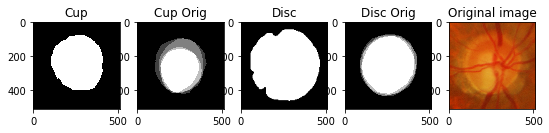

/home/dic/Desktop/hackslash/glycoma/unet1/aug/8d.png


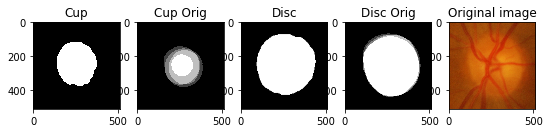

/home/dic/Desktop/hackslash/glycoma/unet1/aug/9d.png


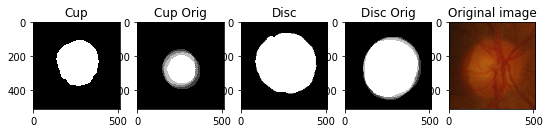

/home/dic/Desktop/hackslash/glycoma/unet1/aug/10d.png


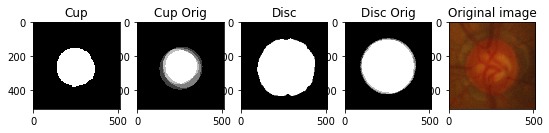

/home/dic/Desktop/hackslash/glycoma/unet1/aug/11d.png


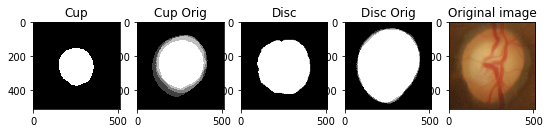

/home/dic/Desktop/hackslash/glycoma/unet1/aug/12d.png


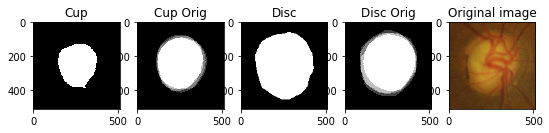

/home/dic/Desktop/hackslash/glycoma/unet1/aug/13d.png


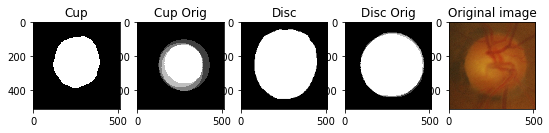

/home/dic/Desktop/hackslash/glycoma/unet1/aug/14d.png


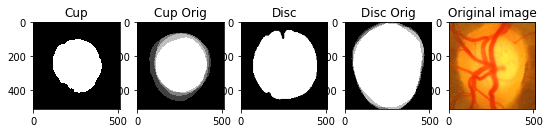

/home/dic/Desktop/hackslash/glycoma/unet1/aug/15d.png


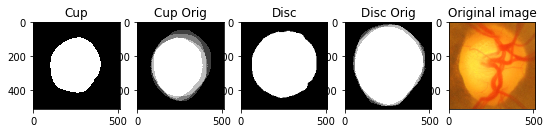

/home/dic/Desktop/hackslash/glycoma/unet1/aug/16d.png


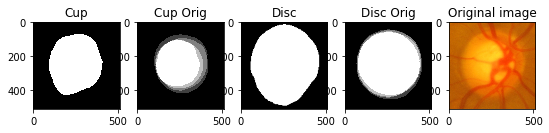

/home/dic/Desktop/hackslash/glycoma/unet1/aug/17d.png


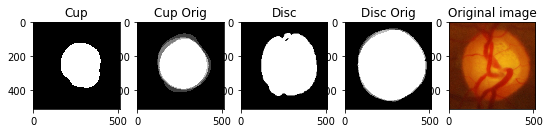

/home/dic/Desktop/hackslash/glycoma/unet1/aug/18d.png


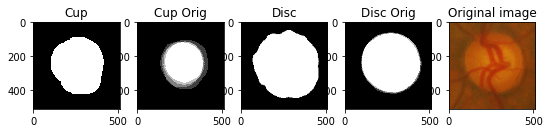

/home/dic/Desktop/hackslash/glycoma/unet1/aug/19d.png


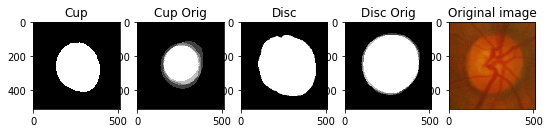

/home/dic/Desktop/hackslash/glycoma/unet1/aug/20d.png


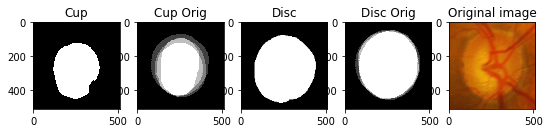

/home/dic/Desktop/hackslash/glycoma/unet1/aug/21d.png


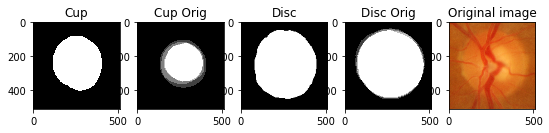

/home/dic/Desktop/hackslash/glycoma/unet1/aug/22d.png


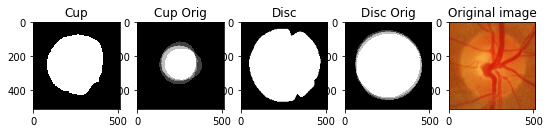

/home/dic/Desktop/hackslash/glycoma/unet1/aug/23d.png


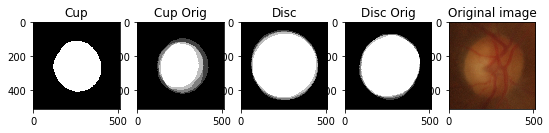

/home/dic/Desktop/hackslash/glycoma/unet1/aug/24d.png


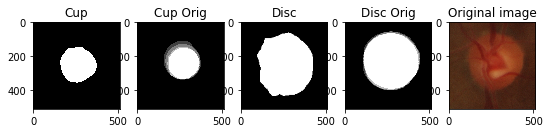

/home/dic/Desktop/hackslash/glycoma/unet1/aug/25d.png


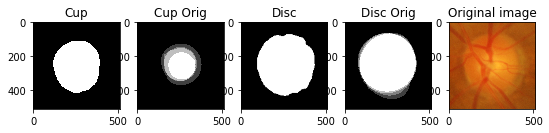

/home/dic/Desktop/hackslash/glycoma/unet1/aug/26d.png


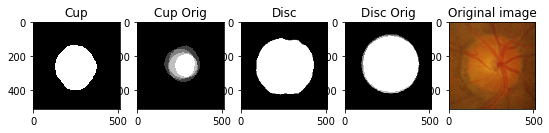

/home/dic/Desktop/hackslash/glycoma/unet1/aug/27d.png


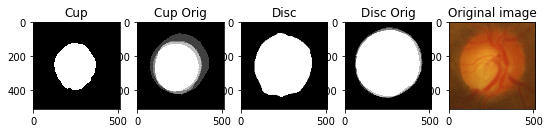

/home/dic/Desktop/hackslash/glycoma/unet1/aug/28d.png


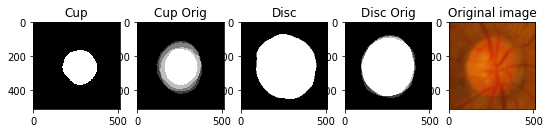

/home/dic/Desktop/hackslash/glycoma/unet1/aug/29d.png


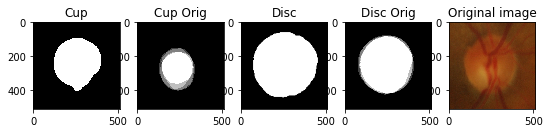

/home/dic/Desktop/hackslash/glycoma/unet1/aug/30d.png


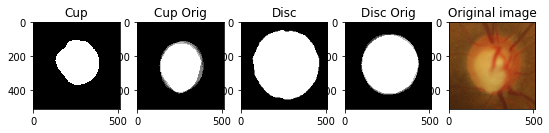

/home/dic/Desktop/hackslash/glycoma/unet1/aug/31d.png


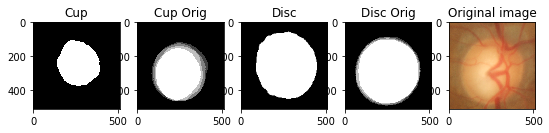

/home/dic/Desktop/hackslash/glycoma/unet1/aug/32d.png


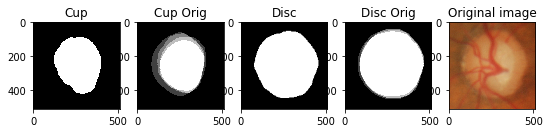

/home/dic/Desktop/hackslash/glycoma/unet1/aug/33d.png


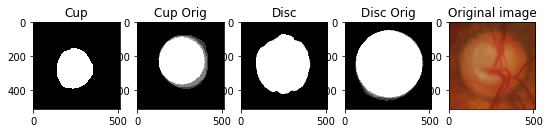

/home/dic/Desktop/hackslash/glycoma/unet1/aug/34d.png


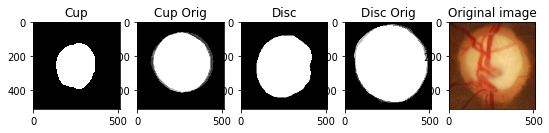

/home/dic/Desktop/hackslash/glycoma/unet1/aug/35d.png


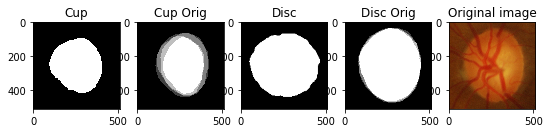

/home/dic/Desktop/hackslash/glycoma/unet1/aug/36d.png


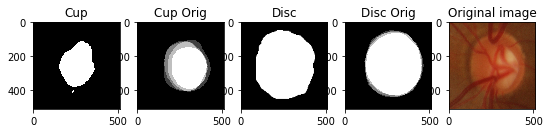

/home/dic/Desktop/hackslash/glycoma/unet1/aug/37d.png


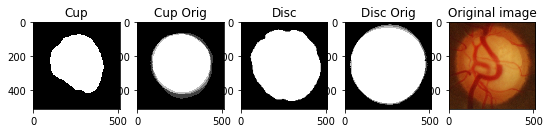

/home/dic/Desktop/hackslash/glycoma/unet1/aug/38d.png


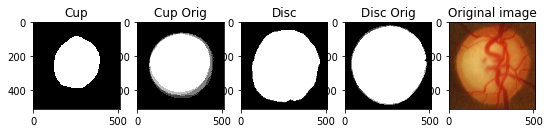

/home/dic/Desktop/hackslash/glycoma/unet1/aug/39d.png


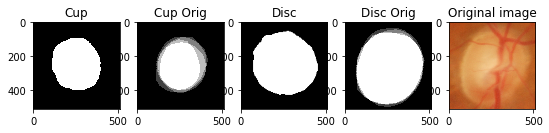

/home/dic/Desktop/hackslash/glycoma/unet1/aug/40d.png


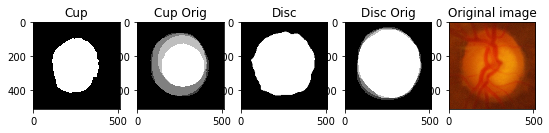

/home/dic/Desktop/hackslash/glycoma/unet1/aug/41d.png


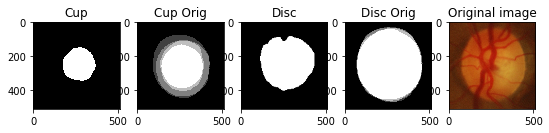

/home/dic/Desktop/hackslash/glycoma/unet1/aug/42d.png


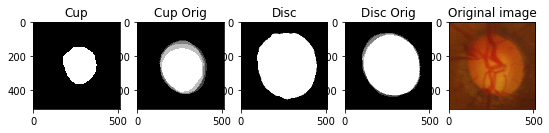

/home/dic/Desktop/hackslash/glycoma/unet1/aug/43d.png


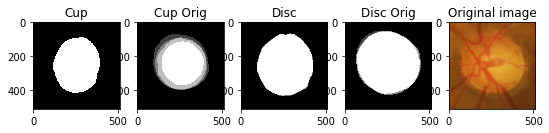

/home/dic/Desktop/hackslash/glycoma/unet1/aug/44d.png


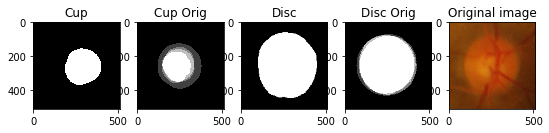

/home/dic/Desktop/hackslash/glycoma/unet1/aug/45d.png


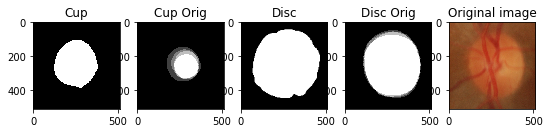

/home/dic/Desktop/hackslash/glycoma/unet1/aug/46d.png


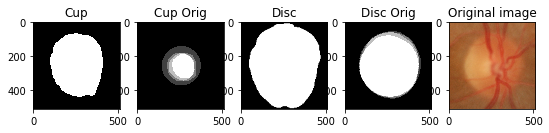

/home/dic/Desktop/hackslash/glycoma/unet1/aug/47d.png


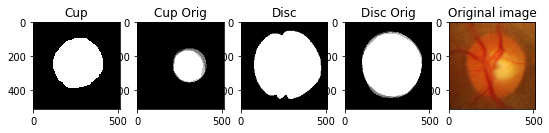

/home/dic/Desktop/hackslash/glycoma/unet1/aug/48d.png


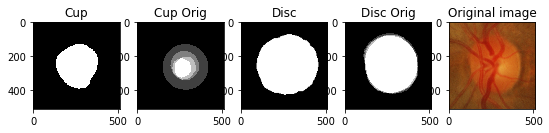

/home/dic/Desktop/hackslash/glycoma/unet1/aug/49d.png


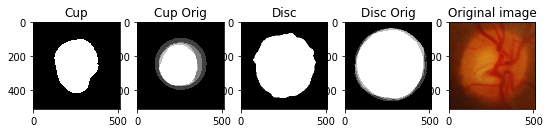

/home/dic/Desktop/hackslash/glycoma/unet1/aug/50d.png


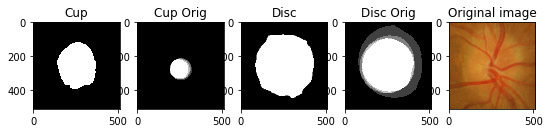

In [52]:
import matplotlib.image as mpimg
from glob import glob
loc = glob(os.path.join('/home/dic/Desktop/hackslash/input_image', "*.png"))
locc = '/home/dic/Desktop/hackslash/input_image/'
loc2 = '/home/dic/Desktop/hackslash/disc/'
loc3 = '/home/dic/Desktop/hackslash/cup/'
loc23 = '/home/dic/Desktop/hackslash/glycoma/unet1/aug/'
i = 0
for img in loc:
    val = str(i)
    val1 = str(i+1)
    extn = '.png'
    imgc = locc + val1 + extn
    image1 = mpimg.imread(imgc)
    img2 = loc2 + val + extn
    img21 = loc23 + val1 + 'd' + extn
    print(img21)
    img3 = loc3 + val + extn
    img31 = loc23 + val1 + 'c' + extn
    image2 = mpimg.imread(img2)
    image21 = mpimg.imread(img21)
    image3 = mpimg.imread(img3)
    image31 = mpimg.imread(img31)
    
    fig = plt.figure(figsize=(9, 4))
    ax = fig.add_subplot(1, 5, 1)
    ax.imshow(image3, cmap=plt.cm.Greys_r)
    ax.set_title('Cup')
    
    ax = fig.add_subplot(1, 5, 2)
    ax.imshow(image31, cmap=plt.cm.Greys_r)
    ax.set_title('Cup Orig')
    
    ax = fig.add_subplot(1, 5, 3)
    ax.imshow(image2, cmap=plt.cm.Greys_r)
    ax.set_title('Disc')
    
    ax = fig.add_subplot(1, 5, 4)
    ax.imshow(image21, cmap=plt.cm.Greys_r)
    ax.set_title('Disc Orig')
    
    ax = fig.add_subplot(1, 5, 5)
    ax.imshow(image1)
    ax.set_title('Original image')
    
    plt.show()
    i += 1


Acquiring scores for the validation set:

In [51]:
#evaluate disc up ratio and predict presence of glaucoma 

In [56]:
import matplotlib.image as mpimg
from glob import glob
loc = glob(os.path.join('/home/dic/Desktop/hackslash/input_image', "*.png"))
loc2 = '/home/dic/Desktop/hackslash/disc/'
loc3 = '/home/dic/Desktop/hackslash/cup/'
i = 0
for img in loc:
    val = str(i)
    extn = '.png'
    image1 = mpimg.imread(img)
    img2 = loc2 + val + extn
    img3 = loc3 + val + extn
    image2 = mpimg.imread(img2)
    image3 = mpimg.imread(img3)
    image2 = np.array(image2)
    image2 = np.where(image2 < 0.3, 0, 1)
    image3 = np.array(image3)
    image3 = np.where(image3 < 0.3, 0, 1)
    
    sum1 = np.sum(image3)
    sum2 = np.sum(image2)
    
    ratio = sum1/sum2
    
    #print("Cup to Disc ratio = ",i, ratio)
    
    i += 1
    
    if ratio > 0.5:
        print ("Progressing towards glaucoma ")
    else:
        print("Patient is healthy.")

Progressing towards glaucoma 
Progressing towards glaucoma 
Progressing towards glaucoma 
Progressing towards glaucoma 
Patient is healthy.
Patient is healthy.
Progressing towards glaucoma 
Patient is healthy.
Progressing towards glaucoma 
Patient is healthy.
Patient is healthy.
Patient is healthy.
Progressing towards glaucoma 
Progressing towards glaucoma 
Progressing towards glaucoma 
Progressing towards glaucoma 
Progressing towards glaucoma 
Progressing towards glaucoma 
Progressing towards glaucoma 
Progressing towards glaucoma 
Progressing towards glaucoma 
Progressing towards glaucoma 
Patient is healthy.
Patient is healthy.
Progressing towards glaucoma 
Progressing towards glaucoma 
Progressing towards glaucoma 
Patient is healthy.
Progressing towards glaucoma 
Patient is healthy.
Patient is healthy.
Progressing towards glaucoma 
Patient is healthy.
Progressing towards glaucoma 
Progressing towards glaucoma 
Patient is healthy.
Progressing towards glaucoma 
Patient is healthy.
